# Jinx 833 Challenger EUW Early Games (Initial 300 secs)

## Load Dataset

In [184]:
from tlol.datasets.replay_dataset import *
dataset = TLoLReplayDataset("./full_db")

## Plot Jinx Position

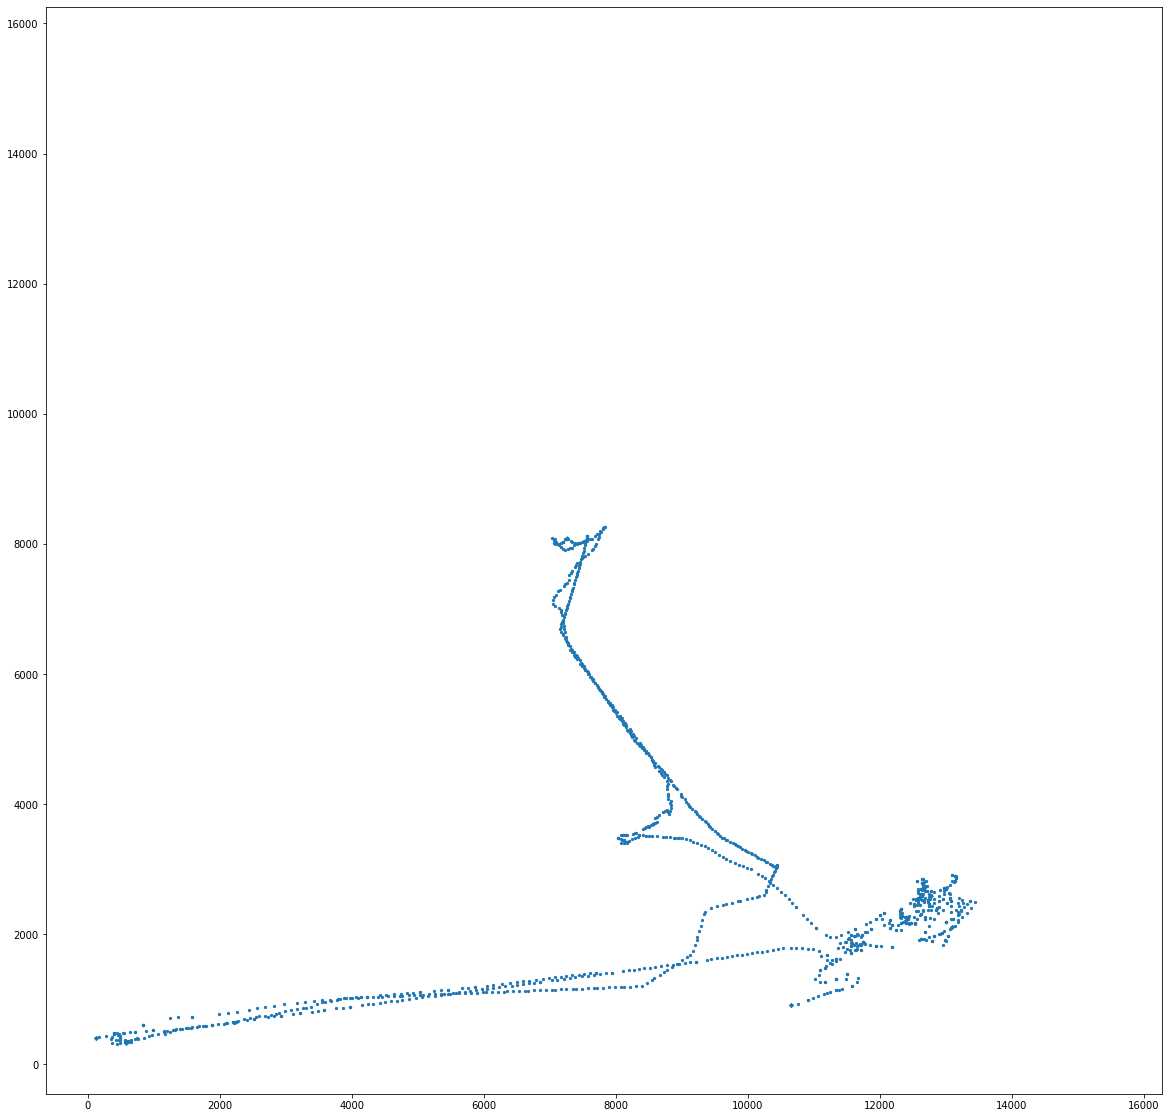

In [199]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
example = dataset[240]

champs   = example["champs"]
minions  = example["minions"]
turrets  = example["turrets"]
jungle   = example["jungle"]
others   = example["others"]
missiles = example["missiles"]

champ_pos_x = champs.iloc[:, 7]
champ_pos_y = champs.iloc[:, 9]
plt.scatter(champ_pos_x, champ_pos_y, s=5)
plt.scatter(15_500, 15_500, c="white")

## Visualise Global Intent Regions

In [186]:
global_region_mult = 2
map_dim  = 16_000
map_width = map_height = map_dim
map_n = int(map_dim / 1000) * global_region_mult
global_intent_region_size = int(map_dim / map_n)
print("Map Region Count, Map Region Size:", map_n, (global_intent_region_size, global_intent_region_size))

Map Region Count, Map Region Size: 32 (500, 500)


### Plot Global Intent Regions

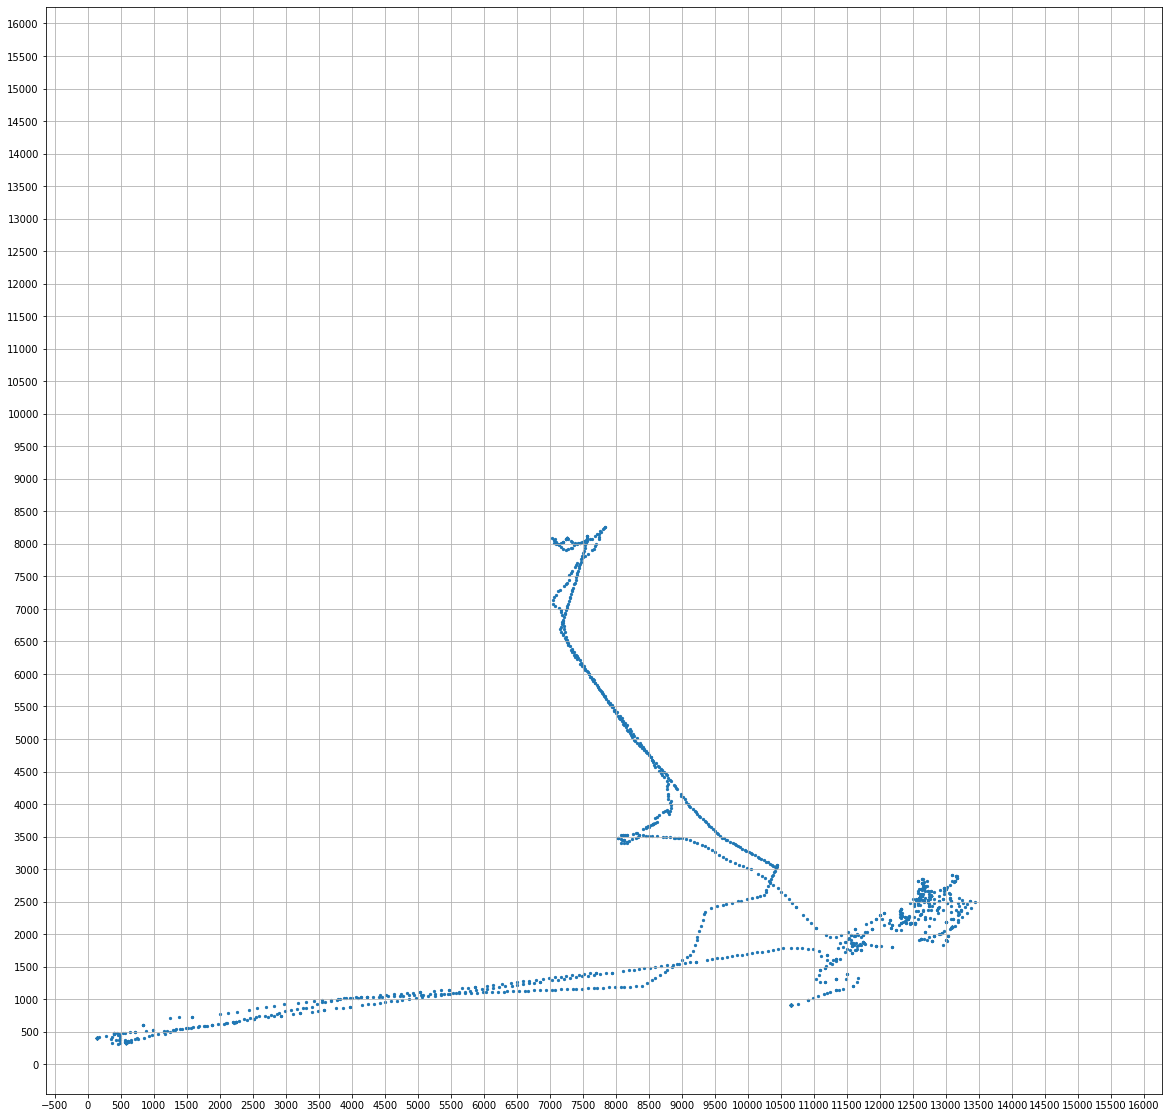

In [187]:
import matplotlib.ticker as plticker

def plot_global_intent_regions(x_pos, y_pos):
    fig, ax = plt.subplots()

    intervals = global_intent_region_size
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')

    ax.scatter(x_pos, y_pos, s=5)
    ax.scatter(15_500, 15_500, c="white")
    
plot_global_intent_regions(champ_pos_x, champ_pos_y)

### Visualise Global Intent Region Hotspots

#### Raw Global Intent Region Heatmap

In [188]:
champ_pos = pd.concat([champ_pos_x, champ_pos_y], axis=1)

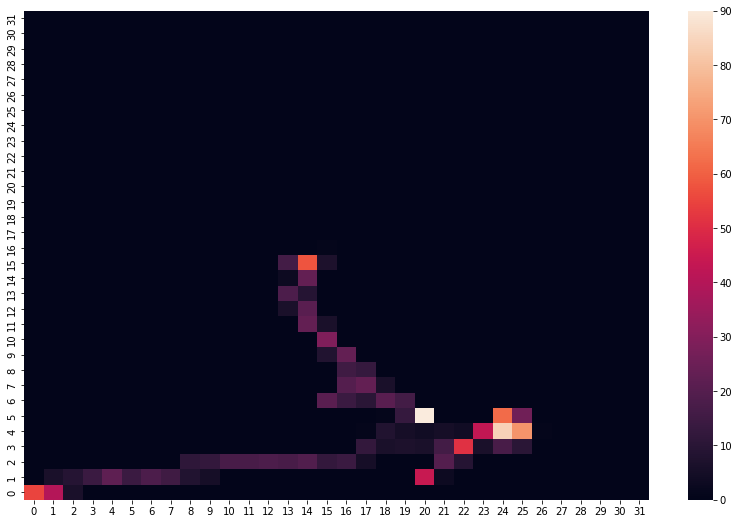

In [189]:
import math
import sys
import seaborn as sns
from numpy import interp

# Reset to default
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

def global_heatmap(pos_df):
    global_intent_sum_matrix = np.zeros((map_n, map_n))

    #%%timeit
    def inc_global_region(row, global_intent_sum_matrix):
        # Gets `N` global intent region for current row for champ
        x_n = math.floor(interp(row[0], [0, 16000], [0, map_n-1]))
        y_n = math.floor(interp(row[1], [0, 16000], [0, map_n-1]))
        global_intent_sum_matrix[y_n, x_n] += 1

    
    pos_df.apply(lambda row: inc_global_region(row, global_intent_sum_matrix), axis=1)
    np.set_printoptions(threshold=8)
    result = global_intent_sum_matrix

    ax = sns.heatmap(result)
    ax.invert_yaxis()
    return result, global_intent_sum_matrix

result, global_intent_sum_matrix = global_heatmap(champ_pos)

#### Log10 Normalised Global Intent Region Heatmap

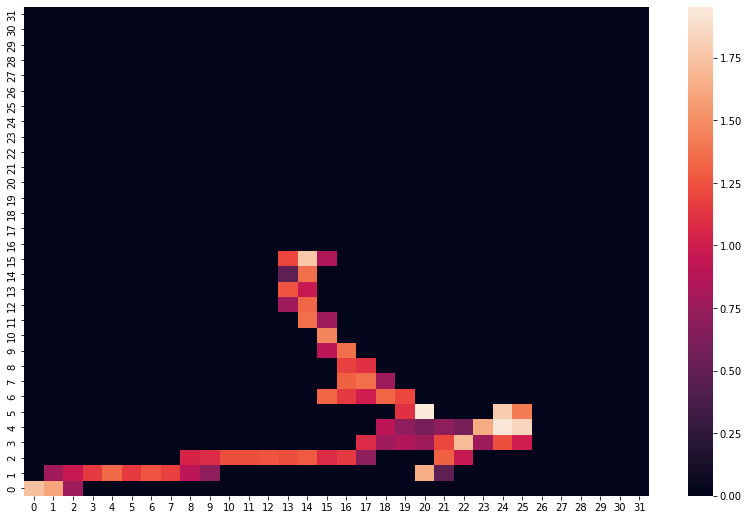

In [190]:
def global_heatmap_normalised(result, global_intent_sum_matrix):
    result = np.where(global_intent_sum_matrix > 0.0000001, global_intent_sum_matrix, 0)
    np.log10(result, out=result, where=result > 0)

    ax = sns.heatmap(result)
    ax.invert_yaxis()

global_heatmap_normalised(result, global_intent_sum_matrix)

## Visualise Local Intent Regions

#### Set Local Intent Region Settings

In [191]:
map_m = int(global_intent_region_size / 50)
local_intent_region_size = int(global_intent_region_size / map_m)
print("Local Region Count, Local Region Size:", map_m, (global_intent_region_size, global_intent_region_size))

Local Region Count, Local Region Size: 10 (500, 500)


#### Get Global Intent Region with Highest Movement Activity

In [192]:
highest_activity_1d = result.argmax()
print("1D-index of highest activity region:", highest_activity_1d)

1D-index of highest activity region: 180


In [193]:
from numpy import unravel_index
highest_activity_2d = \
    unravel_index(global_intent_sum_matrix.argmax(), global_intent_sum_matrix.shape)
highest_activity_2d

(5, 20)

#### Plot Global Intent Region with Highest Movement Activity

10000 2500
cur_champ:      position_x_0  position_z_0
213       10064.0        2558.0
214       10136.0        2576.0
215       10176.0        2584.0
216       10240.0        2600.0
217       10272.0        2652.0
218       10280.0        2682.0
219       10304.0        2738.0
220       10328.0        2788.0
221       10336.0        2808.0
222       10352.0        2848.0
223       10368.0        2888.0
224       10376.0        2908.0
225       10400.0        2958.0
226       10408.0        2978.0
721       10152.0        2932.0
722       10208.0        2898.0
723       10256.0        2862.0
724       10320.0        2810.0
725       10384.0        2758.0
726       10448.0        2706.0
total number of points in local region: 20


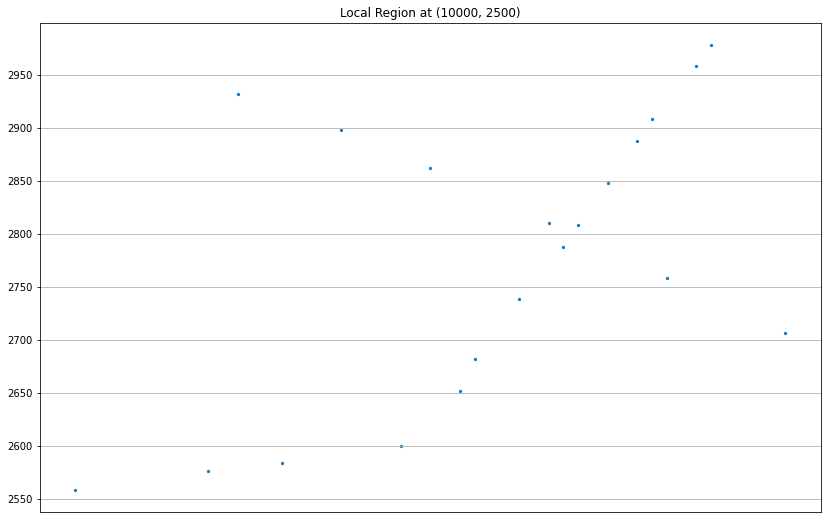

In [197]:
def get_local_actions(row, x_off, y_off):
    # global_intent_region_size
    x = row[0]
    y = row[1]
    """
    print(
        x,
        y,
        x_off,
        y_off,
        x_off + global_intent_region_size * 1,
        y_off + global_intent_region_size * 1,
        x >= x_off and x <= x_off + global_intent_region_size * 1,
        y >= y_off and y <= y_off + global_intent_region_size * 1)
    """
    if   x < x_off or x > x_off + global_intent_region_size * 1:
        return False
    elif y < y_off or y > y_off + global_intent_region_size * 1:
        return False
    else:
        return True

def get_local_actions_only(x_off, y_off, champ_series):
    print(x_off, y_off)
    mask = champ_series.apply(lambda row:\
                              get_local_actions(row, x_off, y_off), axis=1)
    champ_series = champ_series[mask]
    return champ_series

def plot_map_local_scatter(champ_pos, intervals, pos):    
    fig, ax = plt.subplots()
    
    intervals = intervals
    loc = plticker.MultipleLocator(base=intervals)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    
    plt.title(f"Local Region at ({pos[1]*global_intent_region_size}, {pos[0]*global_intent_region_size})")

    # remove (0, 0) rows from a champ

    lens = 0
    cur_champ = get_local_actions_only(
        x_off=pos[1] * global_intent_region_size,
        y_off=pos[0] * global_intent_region_size,
        champ_series=champ_pos,
    )
    lens += len(cur_champ)
    print("cur_champ:", cur_champ)
    ax.scatter(cur_champ.iloc[:,0], cur_champ.iloc[:,1], s=5)
    print("total number of points in local region:", lens)

plot_map_local_scatter(
    champ_pos,
    local_intent_region_size,
    highest_activity_2d)

### Visualise Global Intent Region Hotspots

#### Raw Local Intent Region Heatmap

10000 2500
X, Y: 1 1
X, Y: 2 1
X, Y: 3 1
X, Y: 4 1
X, Y: 4 2
X, Y: 5 3
X, Y: 5 4
X, Y: 5 5
X, Y: 6 5
X, Y: 6 6
X, Y: 6 6
X, Y: 6 7
X, Y: 7 8
X, Y: 7 8
X, Y: 2 7
X, Y: 3 7
X, Y: 4 6
X, Y: 5 5
X, Y: 6 4
X, Y: 8 3


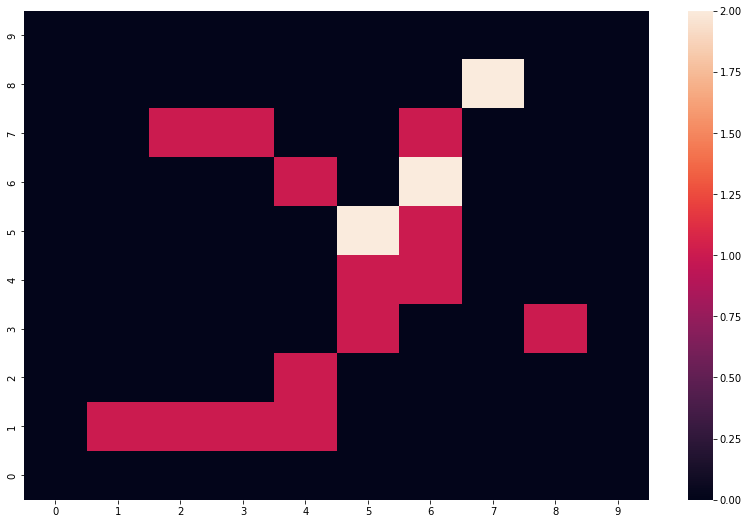

In [195]:
import math
import sys
import seaborn as sns
from numpy import interp

# Reset to default
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

def local_heatmap(champ_pos, pos):
    local_intent_sum_matrix = np.zeros((map_m, map_m))

    #%%timeit
    def inc_local_region(row, local_intent_sum_matrix, x_off, y_off):
        # Gets `N` global intent region for current row for champ
        x_n = math.floor(interp(row[0], [x_off + 0, x_off + global_intent_region_size], [0, map_m-1]))
        y_n = math.floor(interp(row[1], [y_off + 0, y_off + global_intent_region_size], [0, map_m-1]))
        
        print("X, Y:", x_n, y_n)
        local_intent_sum_matrix[y_n, x_n] += 1

    lens = 0
    x_off = pos[1] * global_intent_region_size
    y_off = pos[0] * global_intent_region_size
    cur_champ = get_local_actions_only(
        x_off=x_off,
        y_off=y_off,
        champ_series=champ_pos,
    )
    cur_champ.apply(lambda row: inc_local_region(row, local_intent_sum_matrix, x_off, y_off), axis=1)
    lens += len(cur_champ)

    np.set_printoptions(threshold=8)
    result = local_intent_sum_matrix

    ax = sns.heatmap(result)
    ax.invert_yaxis()
    return result, local_intent_sum_matrix

result, local_intent_sum_matrix = \
    local_heatmap(champ_pos, highest_activity_2d)

#### Log10 Normalised Intent Region Heatmap

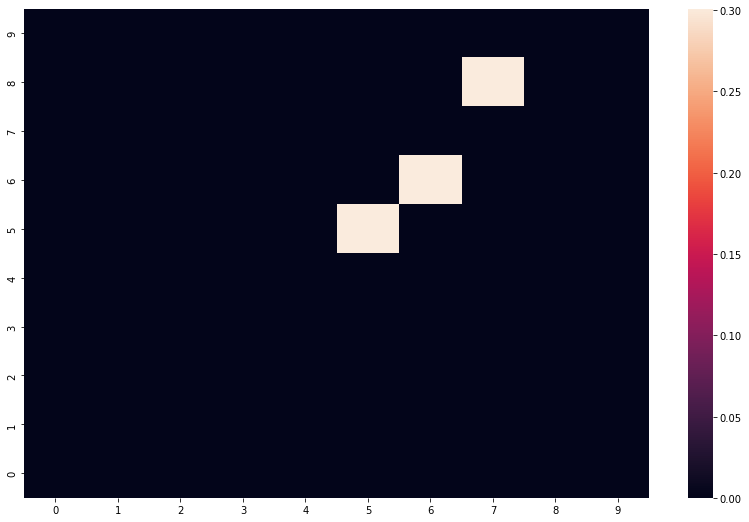

In [196]:
def local_heatmap_normalised(result, local_intent_sum_matrix):
    result = np.where(local_intent_sum_matrix > 0.0000001, local_intent_sum_matrix, 0)
    np.log10(result, out=result, where=result > 0)

    ax = sns.heatmap(result)
    ax.invert_yaxis()
    

local_heatmap_normalised(result, local_intent_sum_matrix)